# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [8]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [9]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


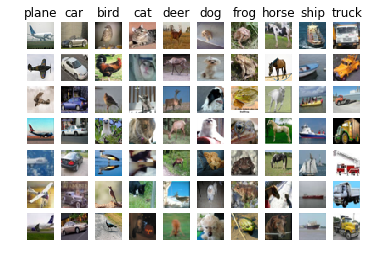

In [10]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [11]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [12]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


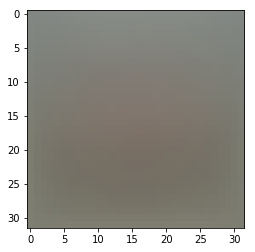

In [13]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [14]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [15]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [16]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.827666


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [17]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -23.389286 analytic: -23.389286, relative error: 8.741401e-12
numerical: 5.994922 analytic: 5.994922, relative error: 3.282555e-11
numerical: 0.841321 analytic: 0.841321, relative error: 1.272687e-10
numerical: 6.930005 analytic: 6.930005, relative error: 4.089918e-11
numerical: 11.793091 analytic: 11.793091, relative error: 2.578989e-11
numerical: -0.169162 analytic: -0.169162, relative error: 2.749649e-09
numerical: -3.601490 analytic: -3.601490, relative error: 2.657896e-11
numerical: -27.374802 analytic: -27.374802, relative error: 6.390389e-13
numerical: -3.753412 analytic: -3.753412, relative error: 1.063011e-12
numerical: -6.572578 analytic: -6.572578, relative error: 2.437546e-11
numerical: -13.158677 analytic: -13.158677, relative error: 1.510393e-11
numerical: -17.348538 analytic: -17.348538, relative error: 1.285740e-12
numerical: -0.235465 analytic: -0.235465, relative error: 4.225996e-10
numerical: -26.827602 analytic: -26.827602, relative error: 1.124184e-11
nu

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** * When the margins are zero, the analytic gradient is zero and the weights matrix will not update.
However, the numerical gradient may have a big swing since, the change in loss can be big.
*

In [18]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.827666e+00 computed in 0.061815s
Vectorized loss: 8.827666e+00 computed in 0.314348s
difference: 0.000000


In [19]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.075161s
Vectorized loss and gradient: computed in 0.004300s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [20]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 796.532813
iteration 100 / 1500: loss 288.827399
iteration 200 / 1500: loss 108.687978
iteration 300 / 1500: loss 42.173422
iteration 400 / 1500: loss 18.947599
iteration 500 / 1500: loss 10.321633
iteration 600 / 1500: loss 6.945062
iteration 700 / 1500: loss 5.610318
iteration 800 / 1500: loss 6.054885
iteration 900 / 1500: loss 5.153383
iteration 1000 / 1500: loss 4.981255
iteration 1100 / 1500: loss 5.714214
iteration 1200 / 1500: loss 5.413949
iteration 1300 / 1500: loss 5.154938
iteration 1400 / 1500: loss 5.300856
That took 2.741657s


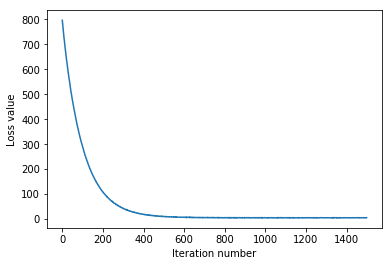

In [21]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [22]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371939
validation accuracy: 0.385000


In [31]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [0.2e-07, 3.3e-07]
regularization_strengths = [1e+04 , 5e+04]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
from cs231n.classifiers import LinearSVM
import numpy as np

 #run a random search for best hyperparameters
num_trial  = 150
    
for i in range(num_trial):
    learning_rate = (learning_rates[1] - learning_rates[0]) * np.random.random_sample() + learning_rates[0]
    reg = (regularization_strengths[1] - regularization_strengths[0]) * np.random.random_sample() + regularization_strengths[0]
    print('### Experiment ', i, ': Learning rate, %e' 
                              %learning_rate, ', Regularization Strength, %f'%reg, ' ###')

    svm = LinearSVM()
    lost_hist = svm.train(X_train, y_train, learning_rate, reg,
                  num_iters=1500, verbose=True)

    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)

    y_val_pred = svm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)

    results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)

    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm


        
        

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

### Experiment  0 : Learning rate, 8.484409e-08 , Regularization Strength, 25852.142902  ###
iteration 0 / 1500: loss 807.872106
iteration 100 / 1500: loss 333.612640
iteration 200 / 1500: loss 140.439961
iteration 300 / 1500: loss 61.475728
iteration 400 / 1500: loss 28.463986
iteration 500 / 1500: loss 14.683772
iteration 600 / 1500: loss 9.562544
iteration 700 / 1500: loss 6.923041
iteration 800 / 1500: loss 5.803264
iteration 900 / 1500: loss 5.533047
iteration 1000 / 1500: loss 5.630868
iteration 1100 / 1500: loss 5.720813
iteration 1200 / 1500: loss 4.917707
iteration 1300 / 1500: loss 5.359187
iteration 1400 / 1500: loss 5.325099
### Experiment  1 : Learning rate, 1.340496e-07 , Regularization Strength, 46001.047831  ###
iteration 0 / 1500: loss 1424.519653
iteration 100 / 1500: loss 122.098372
iteration 200 / 1500: loss 15.329258
iteration 300 / 1500: loss 6.549939
iteration 400 / 1500: loss 6.002197
iteration 500 / 1500: loss 5.175648
iteration 600 / 1500: loss 5.708625
iterat

iteration 1100 / 1500: loss 5.451019
iteration 1200 / 1500: loss 5.474549
iteration 1300 / 1500: loss 5.116013
iteration 1400 / 1500: loss 5.423537
### Experiment  13 : Learning rate, 1.952507e-07 , Regularization Strength, 19642.912493  ###
iteration 0 / 1500: loss 627.985947
iteration 100 / 1500: loss 134.014874
iteration 200 / 1500: loss 32.528818
iteration 300 / 1500: loss 10.311084
iteration 400 / 1500: loss 6.050604
iteration 500 / 1500: loss 5.359680
iteration 600 / 1500: loss 5.134639
iteration 700 / 1500: loss 5.456815
iteration 800 / 1500: loss 5.315177
iteration 900 / 1500: loss 5.581246
iteration 1000 / 1500: loss 5.095681
iteration 1100 / 1500: loss 5.582563
iteration 1200 / 1500: loss 4.752001
iteration 1300 / 1500: loss 4.848259
iteration 1400 / 1500: loss 5.998554
### Experiment  14 : Learning rate, 2.186213e-07 , Regularization Strength, 31213.329766  ###
iteration 0 / 1500: loss 978.833691
iteration 100 / 1500: loss 65.487393
iteration 200 / 1500: loss 9.516288
iterat

iteration 700 / 1500: loss 5.256312
iteration 800 / 1500: loss 5.176732
iteration 900 / 1500: loss 5.280780
iteration 1000 / 1500: loss 5.582575
iteration 1100 / 1500: loss 5.544074
iteration 1200 / 1500: loss 4.881140
iteration 1300 / 1500: loss 5.257027
iteration 1400 / 1500: loss 5.261781
### Experiment  26 : Learning rate, 2.738045e-07 , Regularization Strength, 24822.542365  ###
iteration 0 / 1500: loss 791.272555
iteration 100 / 1500: loss 54.248155
iteration 200 / 1500: loss 8.583866
iteration 300 / 1500: loss 4.914641
iteration 400 / 1500: loss 5.808816
iteration 500 / 1500: loss 5.703595
iteration 600 / 1500: loss 5.676561
iteration 700 / 1500: loss 5.588198
iteration 800 / 1500: loss 5.175488
iteration 900 / 1500: loss 5.614828
iteration 1000 / 1500: loss 5.713329
iteration 1100 / 1500: loss 5.256394
iteration 1200 / 1500: loss 4.982531
iteration 1300 / 1500: loss 5.211757
iteration 1400 / 1500: loss 5.155393
### Experiment  27 : Learning rate, 9.444024e-08 , Regularization S

iteration 200 / 1500: loss 18.837067
iteration 300 / 1500: loss 7.555029
iteration 400 / 1500: loss 5.482172
iteration 500 / 1500: loss 5.335038
iteration 600 / 1500: loss 4.967154
iteration 700 / 1500: loss 5.297770
iteration 800 / 1500: loss 4.920919
iteration 900 / 1500: loss 5.574567
iteration 1000 / 1500: loss 5.319841
iteration 1100 / 1500: loss 4.884401
iteration 1200 / 1500: loss 5.132817
iteration 1300 / 1500: loss 5.518813
iteration 1400 / 1500: loss 5.335178
### Experiment  39 : Learning rate, 2.082105e-07 , Regularization Strength, 10059.140144  ###
iteration 0 / 1500: loss 327.163563
iteration 100 / 1500: loss 138.728660
iteration 200 / 1500: loss 61.213249
iteration 300 / 1500: loss 28.958923
iteration 400 / 1500: loss 15.476303
iteration 500 / 1500: loss 9.890988
iteration 600 / 1500: loss 6.774423
iteration 700 / 1500: loss 5.663663
iteration 800 / 1500: loss 5.548430
iteration 900 / 1500: loss 5.377663
iteration 1000 / 1500: loss 5.008972
iteration 1100 / 1500: loss 5.

### Experiment  51 : Learning rate, 1.660360e-07 , Regularization Strength, 10452.072949  ###
iteration 0 / 1500: loss 338.625792
iteration 100 / 1500: loss 164.871217
iteration 200 / 1500: loss 84.150477
iteration 300 / 1500: loss 44.049677
iteration 400 / 1500: loss 23.923241
iteration 500 / 1500: loss 14.881508
iteration 600 / 1500: loss 9.566794
iteration 700 / 1500: loss 7.290172
iteration 800 / 1500: loss 5.555567
iteration 900 / 1500: loss 5.992157
iteration 1000 / 1500: loss 4.823429
iteration 1100 / 1500: loss 4.703969
iteration 1200 / 1500: loss 5.198833
iteration 1300 / 1500: loss 4.895428
iteration 1400 / 1500: loss 5.411948
### Experiment  52 : Learning rate, 2.233128e-07 , Regularization Strength, 49302.096960  ###
iteration 0 / 1500: loss 1551.443921
iteration 100 / 1500: loss 23.712419
iteration 200 / 1500: loss 5.941623
iteration 300 / 1500: loss 5.955195
iteration 400 / 1500: loss 5.920876
iteration 500 / 1500: loss 5.803694
iteration 600 / 1500: loss 5.666749
iterati

iteration 1000 / 1500: loss 6.051450
iteration 1100 / 1500: loss 5.841060
iteration 1200 / 1500: loss 5.531240
iteration 1300 / 1500: loss 5.532226
iteration 1400 / 1500: loss 5.468659
### Experiment  64 : Learning rate, 2.310275e-07 , Regularization Strength, 48622.133481  ###
iteration 0 / 1500: loss 1510.653826
iteration 100 / 1500: loss 21.158882
iteration 200 / 1500: loss 5.725000
iteration 300 / 1500: loss 5.685300
iteration 400 / 1500: loss 5.881551
iteration 500 / 1500: loss 6.598288
iteration 600 / 1500: loss 5.887862
iteration 700 / 1500: loss 5.580346
iteration 800 / 1500: loss 6.089721
iteration 900 / 1500: loss 6.138738
iteration 1000 / 1500: loss 5.815351
iteration 1100 / 1500: loss 6.044103
iteration 1200 / 1500: loss 6.303534
iteration 1300 / 1500: loss 5.766568
iteration 1400 / 1500: loss 5.915765
### Experiment  65 : Learning rate, 2.305271e-07 , Regularization Strength, 33720.613189  ###
iteration 0 / 1500: loss 1071.661689
iteration 100 / 1500: loss 50.656938
iterat

iteration 600 / 1500: loss 5.798558
iteration 700 / 1500: loss 5.422591
iteration 800 / 1500: loss 5.730360
iteration 900 / 1500: loss 5.024452
iteration 1000 / 1500: loss 5.501563
iteration 1100 / 1500: loss 5.394792
iteration 1200 / 1500: loss 5.171306
iteration 1300 / 1500: loss 5.925830
iteration 1400 / 1500: loss 5.434946
### Experiment  77 : Learning rate, 9.325410e-08 , Regularization Strength, 19582.566773  ###
iteration 0 / 1500: loss 624.893349
iteration 100 / 1500: loss 296.092738
iteration 200 / 1500: loss 143.351352
iteration 300 / 1500: loss 71.921455
iteration 400 / 1500: loss 36.634254
iteration 500 / 1500: loss 20.355407
iteration 600 / 1500: loss 12.498374
iteration 700 / 1500: loss 8.761198
iteration 800 / 1500: loss 7.215072
iteration 900 / 1500: loss 5.943998
iteration 1000 / 1500: loss 5.453338
iteration 1100 / 1500: loss 4.960721
iteration 1200 / 1500: loss 4.951391
iteration 1300 / 1500: loss 4.935959
iteration 1400 / 1500: loss 5.074167
### Experiment  78 : Lea

iteration 200 / 1500: loss 68.581547
iteration 300 / 1500: loss 23.234808
iteration 400 / 1500: loss 10.481655
iteration 500 / 1500: loss 6.272255
iteration 600 / 1500: loss 5.575663
iteration 700 / 1500: loss 5.482490
iteration 800 / 1500: loss 5.108917
iteration 900 / 1500: loss 4.914891
iteration 1000 / 1500: loss 5.276435
iteration 1100 / 1500: loss 5.584271
iteration 1200 / 1500: loss 5.062924
iteration 1300 / 1500: loss 5.791205
iteration 1400 / 1500: loss 5.238296
### Experiment  90 : Learning rate, 2.318961e-07 , Regularization Strength, 37818.459355  ###
iteration 0 / 1500: loss 1178.032514
iteration 100 / 1500: loss 38.402933
iteration 200 / 1500: loss 6.767998
iteration 300 / 1500: loss 5.741153
iteration 400 / 1500: loss 4.780947
iteration 500 / 1500: loss 5.615253
iteration 600 / 1500: loss 5.963552
iteration 700 / 1500: loss 5.487854
iteration 800 / 1500: loss 6.450987
iteration 900 / 1500: loss 5.186875
iteration 1000 / 1500: loss 5.722311
iteration 1100 / 1500: loss 5.3

### Experiment  102 : Learning rate, 2.114818e-07 , Regularization Strength, 30843.067484  ###
iteration 0 / 1500: loss 974.407729
iteration 100 / 1500: loss 73.512481
iteration 200 / 1500: loss 10.039317
iteration 300 / 1500: loss 6.180015
iteration 400 / 1500: loss 5.092972
iteration 500 / 1500: loss 5.367319
iteration 600 / 1500: loss 5.528383
iteration 700 / 1500: loss 5.724868
iteration 800 / 1500: loss 5.267562
iteration 900 / 1500: loss 5.485142
iteration 1000 / 1500: loss 5.730121
iteration 1100 / 1500: loss 5.480752
iteration 1200 / 1500: loss 5.984732
iteration 1300 / 1500: loss 5.268178
iteration 1400 / 1500: loss 5.506559
### Experiment  103 : Learning rate, 9.170830e-08 , Regularization Strength, 28453.844217  ###
iteration 0 / 1500: loss 900.396940
iteration 100 / 1500: loss 313.057599
iteration 200 / 1500: loss 112.848451
iteration 300 / 1500: loss 42.899614
iteration 400 / 1500: loss 18.069121
iteration 500 / 1500: loss 9.547666
iteration 600 / 1500: loss 6.768135
itera

iteration 1000 / 1500: loss 5.130450
iteration 1100 / 1500: loss 4.968631
iteration 1200 / 1500: loss 5.831173
iteration 1300 / 1500: loss 5.806289
iteration 1400 / 1500: loss 5.270048
### Experiment  115 : Learning rate, 1.753541e-07 , Regularization Strength, 40925.109173  ###
iteration 0 / 1500: loss 1288.738313
iteration 100 / 1500: loss 75.187617
iteration 200 / 1500: loss 9.339363
iteration 300 / 1500: loss 5.853183
iteration 400 / 1500: loss 6.174602
iteration 500 / 1500: loss 5.369794
iteration 600 / 1500: loss 5.729822
iteration 700 / 1500: loss 5.524216
iteration 800 / 1500: loss 6.222594
iteration 900 / 1500: loss 5.588521
iteration 1000 / 1500: loss 5.107558
iteration 1100 / 1500: loss 5.747953
iteration 1200 / 1500: loss 5.123744
iteration 1300 / 1500: loss 5.635137
iteration 1400 / 1500: loss 5.328148
### Experiment  116 : Learning rate, 1.356635e-07 , Regularization Strength, 33043.421030  ###
iteration 0 / 1500: loss 1044.221628
iteration 100 / 1500: loss 172.703570
ite

iteration 500 / 1500: loss 5.207012
iteration 600 / 1500: loss 6.216412
iteration 700 / 1500: loss 5.713633
iteration 800 / 1500: loss 4.730359
iteration 900 / 1500: loss 5.098706
iteration 1000 / 1500: loss 5.548195
iteration 1100 / 1500: loss 5.765303
iteration 1200 / 1500: loss 5.477237
iteration 1300 / 1500: loss 5.176051
iteration 1400 / 1500: loss 5.210753
### Experiment  128 : Learning rate, 3.256589e-07 , Regularization Strength, 29937.727886  ###
iteration 0 / 1500: loss 940.444882
iteration 100 / 1500: loss 22.911290
iteration 200 / 1500: loss 5.925331
iteration 300 / 1500: loss 5.412000
iteration 400 / 1500: loss 5.797727
iteration 500 / 1500: loss 5.610296
iteration 600 / 1500: loss 5.440203
iteration 700 / 1500: loss 6.009571
iteration 800 / 1500: loss 6.263242
iteration 900 / 1500: loss 5.654383
iteration 1000 / 1500: loss 5.203821
iteration 1100 / 1500: loss 5.783459
iteration 1200 / 1500: loss 5.947124
iteration 1300 / 1500: loss 5.866636
iteration 1400 / 1500: loss 5.3

iteration 200 / 1500: loss 12.781075
iteration 300 / 1500: loss 6.257442
iteration 400 / 1500: loss 5.725555
iteration 500 / 1500: loss 5.005913
iteration 600 / 1500: loss 5.859031
iteration 700 / 1500: loss 5.056919
iteration 800 / 1500: loss 5.425364
iteration 900 / 1500: loss 5.426176
iteration 1000 / 1500: loss 5.842937
iteration 1100 / 1500: loss 5.391158
iteration 1200 / 1500: loss 5.509368
iteration 1300 / 1500: loss 5.285411
iteration 1400 / 1500: loss 5.393812
### Experiment  141 : Learning rate, 2.131091e-07 , Regularization Strength, 21304.841542  ###
iteration 0 / 1500: loss 679.916919
iteration 100 / 1500: loss 110.496954
iteration 200 / 1500: loss 21.964910
iteration 300 / 1500: loss 8.899195
iteration 400 / 1500: loss 6.116052
iteration 500 / 1500: loss 5.330644
iteration 600 / 1500: loss 5.648130
iteration 700 / 1500: loss 5.470340
iteration 800 / 1500: loss 5.892938
iteration 900 / 1500: loss 4.928429
iteration 1000 / 1500: loss 5.350724
iteration 1100 / 1500: loss 5.4

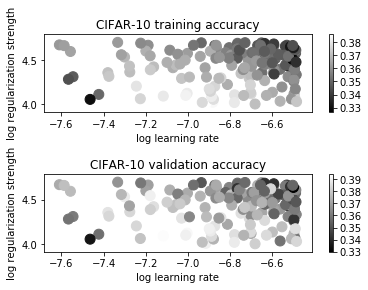

In [33]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.subplots_adjust(wspace=1.6,hspace=0.8)
plt.show()

In [34]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373000


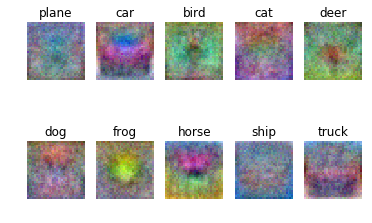

In [35]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *they are composed by basically those examples  we don't predict correctly in the training process.*